In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pydicom as dcm
import os
import nibabel as nib
from tqdm import tqdm
from tensorflow import keras
from keras import layers, models
import tensorflow_io as tfio
import cv2
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import tensorflow_addons as tfa
import glob
import scipy

In [2]:
size = 256

In [3]:
def window_image(img, minn,maxx, intercept, slope, rescale=True):
    img = (img*slope +intercept) 
    
    img[img<minn] = minn 
    img[img>maxx] = maxx 
    if rescale: 
        img = (img - minn) / (maxx - minn)
    return img
    
def get_first_of_dicom_field_as_int(x):
    if type(x) == dcm.multival.MultiValue: return int(x[0])
    else: return int(x)
    
def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value,
                    data[('0028','1051')].value,
                    data[('0028','1052')].value,
                    data[('0028','1053')].value]
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [4]:
def channeling(img1, img2, img3):
    return np.stack([img1, img2, img3], axis=-1)

In [5]:
def load_image(path):
    data_path = '../../Downloads/rsna-2022-cervical-spine-fracture-detection/train_images/'
    UID = path.split('/')[-1][:-7]+"/"
    data = dcm.dcmread(data_path+UID+os.listdir(data_path+UID)[0])
    _, _, intercept, slope = get_windowing(data)
    img = nib.load(path)
    img = img.get_fdata()
    return img, intercept, slope

In [6]:
# def extract(path):
   
#     final_ct = load_image(path+"/"+"1.dcm").reshape(1,size,size)
#     for image in range(1, len(os.listdir(path))):
#         img = load_image(path+"/"+str(image)+".dcm").reshape(1,size,size)
#         final_ct = np.append(final_ct, img, axis=0)
        
#     resized_final_ct = cv2.resize(final_ct[:,:,0], (size,size)).reshape(1,size,size)
#     for i in range(1,final_ct.shape[1]):
#         resized_final_ct = np.append(resized_final_ct, cv2.resize(final_ct[:,:,i], (size,size)).reshape(1,size,size), axis=0)
  

#     return window(resized_final_ct)

In [7]:
bb_df = pd.read_csv("../../Downloads/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv")
df = pd.read_csv("../../Downloads/rsna-2022-cervical-spine-fracture-detection/train.csv")


In [8]:
not_patients = df[df['patient_overall']==0]['StudyInstanceUID'].values
patients = bb_df['StudyInstanceUID'].unique()

In [9]:
bb_df

,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137
...,...,...,...,...,...,...
7212,1.2.826.0.1.3680043.9940,297.23186,115.53983,85.18228,66.52623,140
7213,1.2.826.0.1.3680043.9940,298.00000,117.00000,86.00000,61.00000,141
7214,1.2.826.0.1.3680043.9940,298.00000,119.00000,87.00000,58.00000,142
7215,1.2.826.0.1.3680043.9940,299.00000,120.00000,89.00000,56.00000,143


In [10]:
im = nib.load('../storage/1.2.826.0.1.3680043.11227.nii.gz')
im = im.get_fdata()

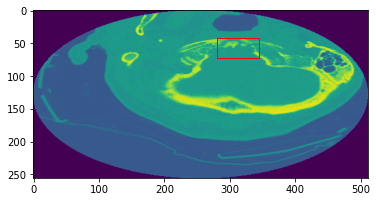

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


fig, ax = plt.subplots()

# Display the image
ax.imshow(im[55])

# Create a Rectangle patch
rect = patches.Rectangle((280, 41), 64, 32, linewidth=1, edgecolor='r', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [12]:
def get_slice_list(uid):
   final_list = set({})
   for i in range(bb_df[bb_df['StudyInstanceUID'] == uid].shape[0]):
      minn = bb_df[bb_df['StudyInstanceUID'] == uid].iloc[i]["x"]
      width = bb_df[bb_df['StudyInstanceUID'] == uid].iloc[i]["width"]
      minn = int(minn//1)
      width = int(width//1)
      slice_list = set(range(minn,minn+width+1))
      final_list.update(slice_list)
   final_list = list(final_list)
   margin = len(final_list)//5
   return final_list[margin:-margin]

In [13]:
!mkdir sagittal_positive_slices

A subdirectory or file sagittal_positive_slices already exists.


In [62]:
path = '../storage/'
for patient in tqdm(patients):
    try:
        slices = get_slice_list(patient)
        ct,intercept,slope = load_image(path+patient+'.nii.gz')
        ct = scipy.ndimage.zoom(ct, (256/ct.shape[0],1,1))
        for slice in slices:
            img1 = window_image(ct[:,:,slice],50,250,intercept,slope)
            img2 = window_image(ct[:,:,slice],250,450,intercept,slope)
            img3 = window_image(ct[:,:,slice],450,650,intercept,slope)
            img = channeling(img1,img2,img3)
            ni_img = nib.Nifti1Image(img, affine=None)
            nib.save(ni_img, '../RSNA-2022-Cervical-Spine-Fracture-Detection/sagittal_positive_slices/'+ patient+"."+str(slice) +".nii.gz")
    
    except:
        print(patient)
        continue

100%|██████████| 235/235 [1:01:43<00:00, 15.76s/it]


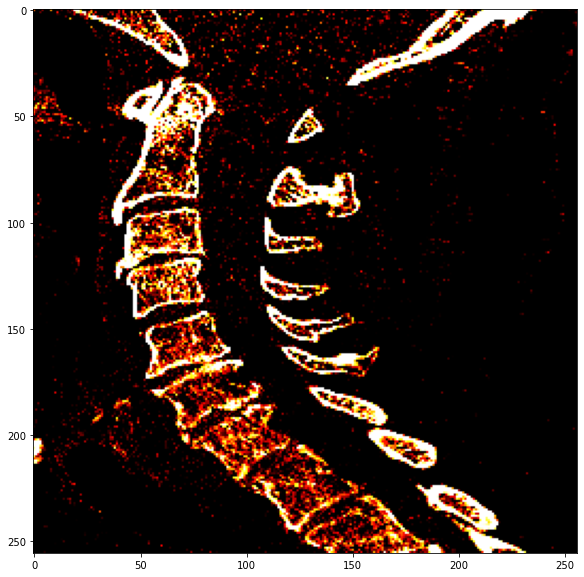

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(img[:,:,:])

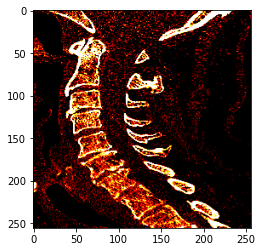

In [15]:
plt.imshow(img)

In [91]:
!mkdir sagittal_negative_slices

A subdirectory or file sagittal_negative_slices already exists.


In [92]:
path = '../storage/'
for patient in tqdm(not_patients):
    try:
        slices = list(range(212,300))
        slices = np.random.choice(slices, size=20, replace=False)
        ct,intercept,slope = load_image(path+patient+'.nii.gz')
        ct = scipy.ndimage.zoom(ct, (256/ct.shape[0],1,1), order=1)
        for slice in slices:
            img1 = window_image(ct[:,:,slice],50,250,intercept,slope)
            img2 = window_image(ct[:,:,slice],250,450,intercept,slope)
            img3 = window_image(ct[:,:,slice],450,650,intercept,slope)
            img = channeling(img1,img2,img3)
            ni_img = nib.Nifti1Image(img, affine=None)
            nib.save(ni_img, '../RSNA-2022-Cervical-Spine-Fracture-Detection/sagittal_negative_slices/'+patient+"."+str(slice) +".nii.gz")
    except:
        print(patient)
        continue

100%|██████████| 1058/1058 [1:40:53<00:00,  5.72s/it]


In [13]:

positive_list = glob.glob('../RSNA-2022-Cervical-Spine-Fracture-Detection/sagittal_positive_slices/*')
negative_list = glob.glob('../RSNA-2022-Cervical-Spine-Fracture-Detection/sagittal_negative_slices/*')

pos_80 = int((len(positive_list)*7)//10)
neg_80 = int((len(negative_list)*7)//10)

train_positive_list = positive_list[:pos_80]
test_positive_list = positive_list[pos_80:]
train_negative_list = negative_list[:neg_80]
test_negative_list = negative_list[neg_80:]


train_positive_list.extend(train_negative_list[::2])
test_positive_list.extend(test_negative_list[::2])


final_train_list = np.random.choice(train_positive_list, size = len(train_positive_list), replace=False)
final_test_list = np.random.choice(test_positive_list, size = len(test_positive_list), replace=False)

15426

In [16]:
# def data_gen_multi():
#     for image in final_train_list:
#         if image.split("_")[1] == "positive":
#             uid = image.split('\\')[1]
#             weired_len = 8 + len(uid.split('.')[-3])
#             uid = uid[:-weired_len]
#             pdf = df[df['StudyInstanceUID'] == uid]
#             co = pdf['patient_overall'].values[0]
#             c1 = pdf['C1'].values[0]
#             c2 = pdf['C2'].values[0]
#             c3 = pdf['C3'].values[0]
#             c4 = pdf['C4'].values[0]
#             c5 = pdf['C5'].values[0]
#             c6 = pdf['C6'].values[0]
#             c7 = pdf['C7'].values[0]
#             img = nib.load(image)
#             img = img.get_fdata()
#             yield ({"input_1": cv2.resize(img, (256, 256))},
#                   {
#                                         'c1': c1,
#                                         'c2': c2,
#                                         'c3': c3,
#                                         'c4': c4,
#                                         'c5': c5,
#                                         'c6': c6,
#                                         'c7': c7,},
#                       { 
#                                     'c1': c1+1,
#                                     'c2': c2+1,
#                                     'c3': c3+1,
#                                     'c4': c4+1,
#                                     'c5': c5+1,
#                                     'c6': c6+1,
#                                     'c7': c7+1})
#         else:
#             img = nib.load(image)
#             img = img.get_fdata()
#             yield ({"input_1": cv2.resize(img, (256, 256))},
#                 {
#                                         'c1': 0,
#                                         'c2': 0,
#                                         'c3': 0,
#                                         'c4': 0,
#                                         'c5': 0,
#                                         'c6': 0,
#                                         'c7': 0,},
#                       {
#                                     'c1': 1,
#                                     'c2': 1,
#                                     'c3': 1,
#                                     'c4': 1,
#                                     'c5': 1,
#                                     'c6': 1,
#                                     'c7': 1})

# def test_gen_multi():
#     for image in final_test_list:
#         if image.split("_")[1] == "positive":
#             uid = image.split('\\')[1]
#             weired_len = 8 + len(uid.split('.')[-3])
#             uid = uid[:-weired_len]
#             pdf = df[df['StudyInstanceUID'] == uid]
           
#             c1 = pdf['C1'].values[0]
#             c2 = pdf['C2'].values[0]
#             c3 = pdf['C3'].values[0]
#             c4 = pdf['C4'].values[0]
#             c5 = pdf['C5'].values[0]
#             c6 = pdf['C6'].values[0]
#             c7 = pdf['C7'].values[0]
#             img = nib.load(image)
#             img = img.get_fdata()
#             yield ({"input_1": cv2.resize(img, (256, 256))},
#                   { 
#                                         'c1': c1,
#                                         'c2': c2,
#                                         'c3': c3,
#                                         'c4': c4,
#                                         'c5': c5,
#                                         'c6': c6,
#                                         'c7': c7,},
#                       {
#                                     'c1': c1+1,
#                                     'c2': c2+1,
#                                     'c3': c3+1,
#                                     'c4': c4+1,
#                                     'c5': c5+1,
#                                     'c6': c6+1,
#                                     'c7': c7+1})
#         else:
#             img = nib.load(image)
#             img = img.get_fdata()
#             yield ({"input_1": cv2.resize(img, (256, 256))},
#                 { 
#                                         'c1': 0,
#                                         'c2': 0,
#                                         'c3': 0,
#                                         'c4': 0,
#                                         'c5': 0,
#                                         'c6': 0,
#                                         'c7': 0,},
#                       { 
#                                     'c1': 1,
#                                     'c2': 1,
#                                     'c3': 1,
#                                     'c4': 1,
#                                     'c5': 1,
#                                     'c6': 1,
#                                     'c7': 1})


In [14]:
def data_gen():
    for image in final_train_list:
        if image.split("_")[1] == "positive":
            uid = image.split('\\')[1]
            weired_len = 8 + len(uid.split('.')[-3])
            uid = uid[:-weired_len]
            pdf = df[df['StudyInstanceUID'] == uid]
            co = pdf['patient_overall'].values[0]
        
            img = nib.load(image)
            img = img.get_fdata()
            yield ({"input_1": cv2.resize(img, (256, 256))},
                  {'co': co},
                      {'co': 2})
        else:
            img = nib.load(image)
            img = img.get_fdata()
            yield ({"input_1": cv2.resize(img, (256, 256))},
                {'co': 0},
                      {'co': 1})

def test_gen():
    for image in final_test_list:
        if image.split("_")[1] == "positive":
            uid = image.split('\\')[1]
            weired_len = 8 + len(uid.split('.')[-3])
            uid = uid[:-weired_len]
            pdf = df[df['StudyInstanceUID'] == uid]
            co = pdf['patient_overall'].values[0]
            img = nib.load(image)
            img = img.get_fdata()
            yield ({"input_1": cv2.resize(img, (256, 256))},
                  {'co': co},
                      {'co': 2})
        else:
            img = nib.load(image)
            img = img.get_fdata()
            yield ({"input_1": cv2.resize(img, (256, 256))},
                {'co': 0},
                      {'co': 1})


In [15]:
dataset = tf.data.Dataset.from_generator(
     data_gen,
     ({"input_1":tf.float32}, 
     {'co':tf.int8},
     {'co':tf.int8}),
    ({"input_1":tf.TensorShape([256,256,3])}, 
     {"co": tf.TensorShape([])},
    {"co": tf.TensorShape([])})
)

testset = tf.data.Dataset.from_generator(
     test_gen,
     ({"input_1":tf.float32}, 
     {'co':tf.int8},
     {'co':tf.int8}),
    ({"input_1":tf.TensorShape([256,256,3])}, 
     {"co": tf.TensorShape([])},
    {"co": tf.TensorShape([])})
)

In [16]:
# dataset_multi = tf.data.Dataset.from_generator(
#      data_gen_multi,
#      ({"input_1":tf.float32}, 
#      {
#      'c1':tf.int8,
#      'c2':tf.int8,
#      'c3':tf.int8,
#      'c4':tf.int8,
#      'c5':tf.int8,
#      'c6':tf.int8,
#      'c7':tf.int8},
#      {
#      'c1':tf.int8,
#      'c2':tf.int8,
#      'c3':tf.int8,
#      'c4':tf.int8,
#      'c5':tf.int8,
#      'c6':tf.int8,
#      'c7':tf.int8}),
#     ({"input_1":tf.TensorShape([256,256,3])}, 
#      {
#      "c1": tf.TensorShape([]),
#      "c2": tf.TensorShape([]),
#      "c3": tf.TensorShape([]),
#      "c4": tf.TensorShape([]),
#      "c5": tf.TensorShape([]),
#      "c6": tf.TensorShape([]),
#      "c7": tf.TensorShape([])},
#     {
#      "c1": tf.TensorShape([]),
#      "c2": tf.TensorShape([]),
#      "c3": tf.TensorShape([]),
#      "c4": tf.TensorShape([]),
#      "c5": tf.TensorShape([]),
#      "c6": tf.TensorShape([]),
#      "c7": tf.TensorShape([])})
# )

# testset_multi = tf.data.Dataset.from_generator(
#      test_gen_multi,
#      ({"input_1":tf.float32}, 
#      {
#      'c1':tf.int8,
#      'c2':tf.int8,
#      'c3':tf.int8,
#      'c4':tf.int8,
#      'c5':tf.int8,
#      'c6':tf.int8,
#      'c7':tf.int8},
#      {
#      'c1':tf.int8,
#      'c2':tf.int8,
#      'c3':tf.int8,
#      'c4':tf.int8,
#      'c5':tf.int8,
#      'c6':tf.int8,
#      'c7':tf.int8}),
#     ({"input_1":tf.TensorShape([256,256,3])}, 
#      { 
#      "c1": tf.TensorShape([]),
#      "c2": tf.TensorShape([]),
#      "c3": tf.TensorShape([]),
#      "c4": tf.TensorShape([]),
#      "c5": tf.TensorShape([]),
#      "c6": tf.TensorShape([]),
#      "c7": tf.TensorShape([])},
#     { 
#      "c1": tf.TensorShape([]),
#      "c2": tf.TensorShape([]),
#      "c3": tf.TensorShape([]),
#      "c4": tf.TensorShape([]),
#      "c5": tf.TensorShape([]),
#      "c6": tf.TensorShape([]),
#      "c7": tf.TensorShape([])})
# )

In [17]:
augment = tf.keras.Sequential([
  keras.layers.RandomRotation((-0.4,0.4)),
  keras.layers.GaussianNoise(0.2),
  keras.layers.RandomContrast(0.2, seed=2),
  keras.layers.RandomFlip(mode='horizontal_and_vertical', seed=2),
  keras.layers.RandomZoom(
    (-0.2, 0.2),
    (-0.2, 0.2),
    fill_mode='reflect',
    interpolation='bilinear',
    seed=3)
])

In [31]:
dataset = dataset.map(lambda x, y, z: (augment(x['input_1']), y, z), 
              num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(15)
dataset = dataset.prefetch(1)


testset = testset.batch(15)
testset = testset.prefetch(1)

In [32]:
base = tf.keras.applications.ResNet101(
    include_top=False,
    weights="imagenet",
    pooling='avg',
    input_shape=(256,256,3),
)

inputs = keras.Input((256, 256, 3), name = "input_1")
x = base(inputs)

x0 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2', name='x0_2')(x)
x0 = tf.keras.layers.Dropout(0.5, name='x0_3')(x0)
x0 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2', name='x0_4')(x0)
x0 = tf.keras.layers.Dropout(0.5, name='x0_5')(x0)

outputo = keras.layers.Dense(1 ,activation = 'sigmoid', name="co")(x0)
                                               
model = keras.models.Model(inputs=inputs, outputs=outputo)

In [33]:
# base_multi = tf.keras.applications.ResNet50(
#     include_top=False,
#     weights="imagenet",
#     pooling='avg',
#     input_shape=(256,256,3),
# )

# inputs = keras.Input((256, 256, 3), name = "input_1")
# x = base_multi(inputs)

# x1 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x)
# x1 = tf.keras.layers.Dropout(0.4)(x1)
# x1 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x)
# x1 = tf.keras.layers.Dropout(0.4)(x1)

# x2 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x)
# x2 = tf.keras.layers.Dropout(0.4)(x2)
# x2 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x2)
# x2 = tf.keras.layers.Dropout(0.4)(x2)

# x3 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x)
# x3 = tf.keras.layers.Dropout(0.4)(x3)
# x3 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x3)
# x3 = tf.keras.layers.Dropout(0.4)(x3)

# x4 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x)
# x4 = tf.keras.layers.Dropout(0.4)(x4)
# x4 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x4)
# x4 = tf.keras.layers.Dropout(0.4)(x4)

# x5 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x)
# x5 = tf.keras.layers.Dropout(0.4)(x5)
# x5 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x5)
# x5 = tf.keras.layers.Dropout(0.4)(x5)

# x6 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2')(x)
# x6 = tf.keras.layers.Dropout(0.4)(x6)
# x6 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(x6)
# x6 = tf.keras.layers.Dropout(0.4)(x6)

# x7 = tf.keras.layers.Dense(128, activation='relu')(x7)
# x7 = tf.keras.layers.Dropout(0.4)(x7)
# x7 = tf.keras.layers.Dense(32, activation='relu')(x7)
# x7 = tf.keras.layers.Dropout(0.4)(x7)

# output1 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c1")(x1)
# output2 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c2")(x2)
# output3 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c3")(x3)
# output4 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c4")(x4)
# output5 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c5")(x5)
# output6 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c6")(x6)
# output7 = keras.layers.Dense(1 ,activation = 'sigmoid', name="c7")(x7)
                                               
# model_multi = keras.models.Model(inputs=inputs, outputs=[output1,output2,output3,output4,output5,output6,output7])

In [34]:
def lr_schedule(epoch, lr):
    return lr/((epoch+2)/2)

In [35]:
opt = tfa.optimizers.AdamW(
    weight_decay=2e-4,
    learning_rate = 0.0009,
    beta_1 = 0.9,
    beta_2 = 0.999,
    epsilon = 1e-07,
    name = 'AdamW',
)
loss = tf.keras.losses.BinaryCrossentropy(
    label_smoothing=0.2, 
    reduction=tf.keras.losses.Reduction.AUTO,
    name='binary_crossentropy'
)
metrics = [tf.keras.metrics.AUC()]
model.compile(optimizer=opt,
              loss={"co": loss},
                metrics={"co": [tf.keras.metrics.AUC()]})

In [36]:
# model_multi.compile(optimizer=opt,
#               loss={
#                    "c1": loss,
#                    "c2": loss,
#                    "c3": loss,
#                    "c4": loss,
#                    "c5": loss,
#                    "c6": loss,
#                    "c7": loss,},
#                 metrics={
#                 "c1": [tf.keras.metrics.AUC()], 
#                 "c2": [tf.keras.metrics.AUC()], 
#                 "c3": [tf.keras.metrics.AUC()], 
#                 "c4": [tf.keras.metrics.AUC()], 
#                 "c5": [tf.keras.metrics.AUC()], 
#                 "c6": [tf.keras.metrics.AUC()], 
#                 "c7": [tf.keras.metrics.AUC()]})

In [37]:
!mkdir best_weights_single_class

A subdirectory or file best_weights_single_class already exists.


In [38]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = './best_weights_single_class/model',
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
)

In [39]:
history = model.fit(dataset, validation_data = testset, epochs=10, callbacks=[model_checkpoint, tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

Epoch 1/10
   2400/Unknown - 865s 350ms/step - loss: 1.0144 - auc_1: 0.7961WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.
2400/2400 [==============================] - 1104s 450ms/step - loss: 1.0144 - auc_1: 0.7961 - val_loss: 0.9184 - val_auc_1: 0.7569 - lr: 9.0000e-04
Epoch 2/10
2400/2400 [==============================] - 1199s 499ms/step - loss: 0.8042 - auc_1: 0.8398 - val_loss: 0.9349 - val_auc_1: 0.6896 - lr: 6.0000e-04
Epoch 3/10
  38/2400 [..............................] - ETA: 12:18 - loss: 0.7907 - auc_1: 0.8550

KeyboardInterrupt: 

In [111]:
model.load_weights('./best_weights_single_class/model')

In [ ]:
model_multi.load_weights('./best_weights_single_class/model')

In [77]:
model.evaluate(testset)

481/481 [==============================] - 56s 115ms/step - loss: 0.9648 - auc_5: 0.6522


[0.9648289084434509, 0.6522367596626282]

In [25]:
model.evaluate(testset)

481/481 [==============================] - 65s 134ms/step - loss: 6.4650 - co_loss: 0.9899 - c1_loss: 0.7320 - c2_loss: 0.7548 - c3_loss: 0.6749 - c4_loss: 0.7580 - c5_loss: 0.8143 - c6_loss: 0.8661 - c7_loss: 0.8418 - co_auc_1: 0.5665 - c1_auc_2: 0.4908 - c2_auc_3: 0.5388 - c3_auc_4: 0.4806 - c4_auc_5: 0.4318 - c5_auc_6: 0.5081 - c6_auc_7: 0.5361 - c7_auc_8: 0.5889


[6.464985370635986,
 0.9898766875267029,
 0.7319911122322083,
 0.7548388242721558,
 0.6748754978179932,
 0.7579888105392456,
 0.8142767548561096,
 0.8660964369773865,
 0.8417942523956299,
 0.5664525032043457,
 0.4907821714878082,
 0.5388445854187012,
 0.48060786724090576,
 0.431837260723114,
 0.5080649852752686,
 0.5361403822898865,
 0.5889407992362976]

In [120]:
positive_df = df[df['patient_overall']==1]

In [121]:
positive_df.iloc[0]

StudyInstanceUID    1.2.826.0.1.3680043.6200
patient_overall                            1
C1                                         1
C2                                         1
C3                                         0
C4                                         0
C5                                         0
C6                                         0
C7                                         0
Name: 0, dtype: object

In [122]:
not_bb_pos = []
for positive in positive_df['StudyInstanceUID']:
    if positive not in bb_df['StudyInstanceUID'].unique():
        not_bb_pos.append(positive)

In [123]:
# df[df['StudyInstanceUID'] == not_bb_pos[670]]
positive_df.iloc[100]

StudyInstanceUID    1.2.826.0.1.3680043.11849
patient_overall                             1
C1                                          0
C2                                          0
C3                                          0
C4                                          0
C5                                          1
C6                                          1
C7                                          0
Name: 187, dtype: object

In [124]:
def get_sample(patient):
    path = '../storage/'
    ct,intercept,slope = load_image(path+patient+'.nii.gz')
    ct = scipy.ndimage.zoom(ct, (256/ct.shape[0],1,1))
    ct = np.transpose(ct, axes=[2,0,1])
    
    img1 = window_image(ct,100,600,intercept,slope)
    img2 = window_image(ct,600,1100,intercept,slope)
    img3 = window_image(ct,1100,1600,intercept,slope)
    return channeling(img1,img2,img3)
        

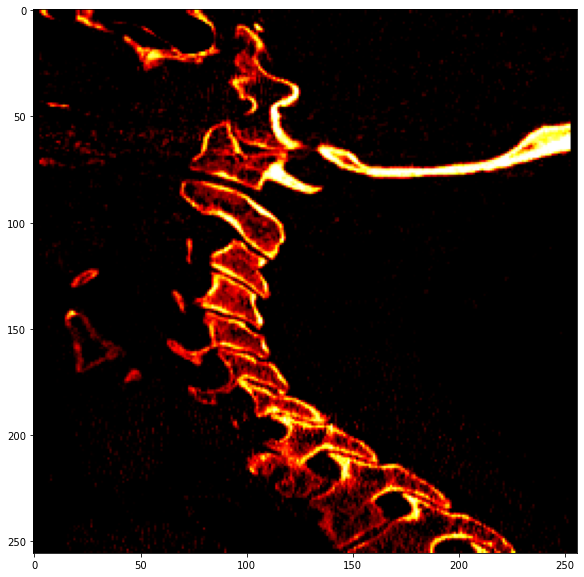

In [125]:
plt.figure(figsize=(10,10))
plt.imshow(get_sample(positive_df.iloc[100]['StudyInstanceUID'])[100])

In [126]:
pred = model.predict(get_sample(positive_df.iloc[100]['StudyInstanceUID'])[100:140:2])

1/1 [==============================] - 0s 51ms/step


In [127]:
pred

array([[0.7165792 ],
       [0.7196881 ],
       [0.69854116],
       [0.6938094 ],
       [0.7049006 ],
       [0.6843363 ],
       [0.6824677 ],
       [0.6661156 ],
       [0.68697166],
       [0.6722427 ],
       [0.65415   ],
       [0.6404756 ],
       [0.6295779 ],
       [0.615755  ],
       [0.6120026 ],
       [0.6005544 ],
       [0.6039947 ],
       [0.61505044],
       [0.6040759 ],
       [0.60229015]], dtype=float32)

In [86]:
!mkdir final_model

A subdirectory or file final_model already exists.


In [135]:
model.save("./final_model/model")

INFO:tensorflow:Assets written to: ./final_model/model\assets


INFO:tensorflow:Assets written to: ./final_model/model\assets


In [137]:
!mkdir feature_extractor


In [147]:
base.save('./feature_extractor/feature_extractor')

INFO:tensorflow:Assets written to: ./feature_extractor/feature_extractor\assets


INFO:tensorflow:Assets written to: ./feature_extractor/feature_extractor\assets


In [148]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 2048)         23587712    ['input_1[0][0]']                
                                                                                                  
 dropout_21 (Dropout)           (None, 2048)         0           ['resnet50[0][0]']               
                                                                                                  
 dropout_24 (Dropout)           (None, 2048)         0           ['resnet50[0][0]']         